# Preparing Aerial Imagery for Crop Classification

**Data:** Competition https://zindi.africa/competitions/farm-pin-crop-detection-challenge/data 
* `train.zip` containing GeoJSON  
* `201–01–01.zip` containing GeoTIFF files  

**Article:** https://medium.datadriveninvestor.com/preparing-aerial-imagery-for-crop-classification-ce05d3601c68 

In [7]:
import os

import rasterio
from rasterio.plot import reshape_as_image, show, show_hist
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

data/2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_TCI.jp2
3
JP2OpenJPEG
(None, None, None)
0
255


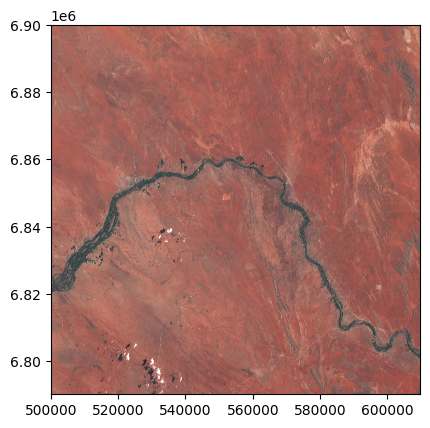

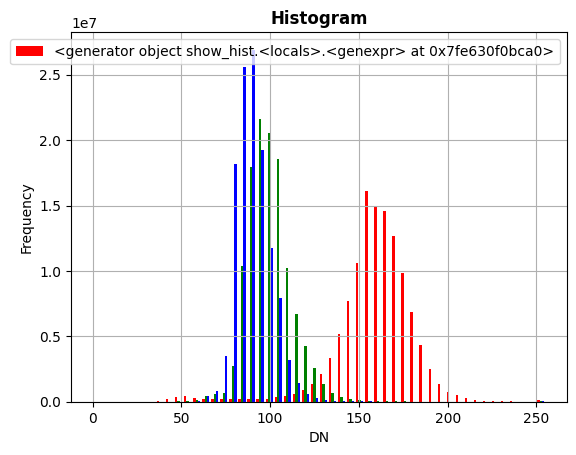

In [8]:
raster_path = "data/2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_TCI.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:  # open image in the read mode
    raster_img = src.read()   # read image as numpy array
    raster_meta = src.meta    # metadata of the image
    
    print(src.name)
    print(src.count)
    print(src.driver)
    print(src.descriptions)
    print(raster_img.min())
    print(raster_img.max())
    
    # visualization by rasterio
    show(src)
    show_hist(src, bins=50)


### Interpreting the histogram can provide insights into the image:
A color represents pixels of each band (r, g, b)

* A histogram skewed to the left indicates that the image might be dark (many low pixel values).  
* A histogram skewed to the right indicates that the image might be bright (many high pixel values).  
* Peaks can indicate dominant colors or features in the image.  

In [3]:
print(raster_img.shape)
print(type(raster_img))

(3, 10980, 10980)
<class 'numpy.ndarray'>


In [4]:
print(raster_meta)   # Question: what is nodata?

{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 6900040.0)}


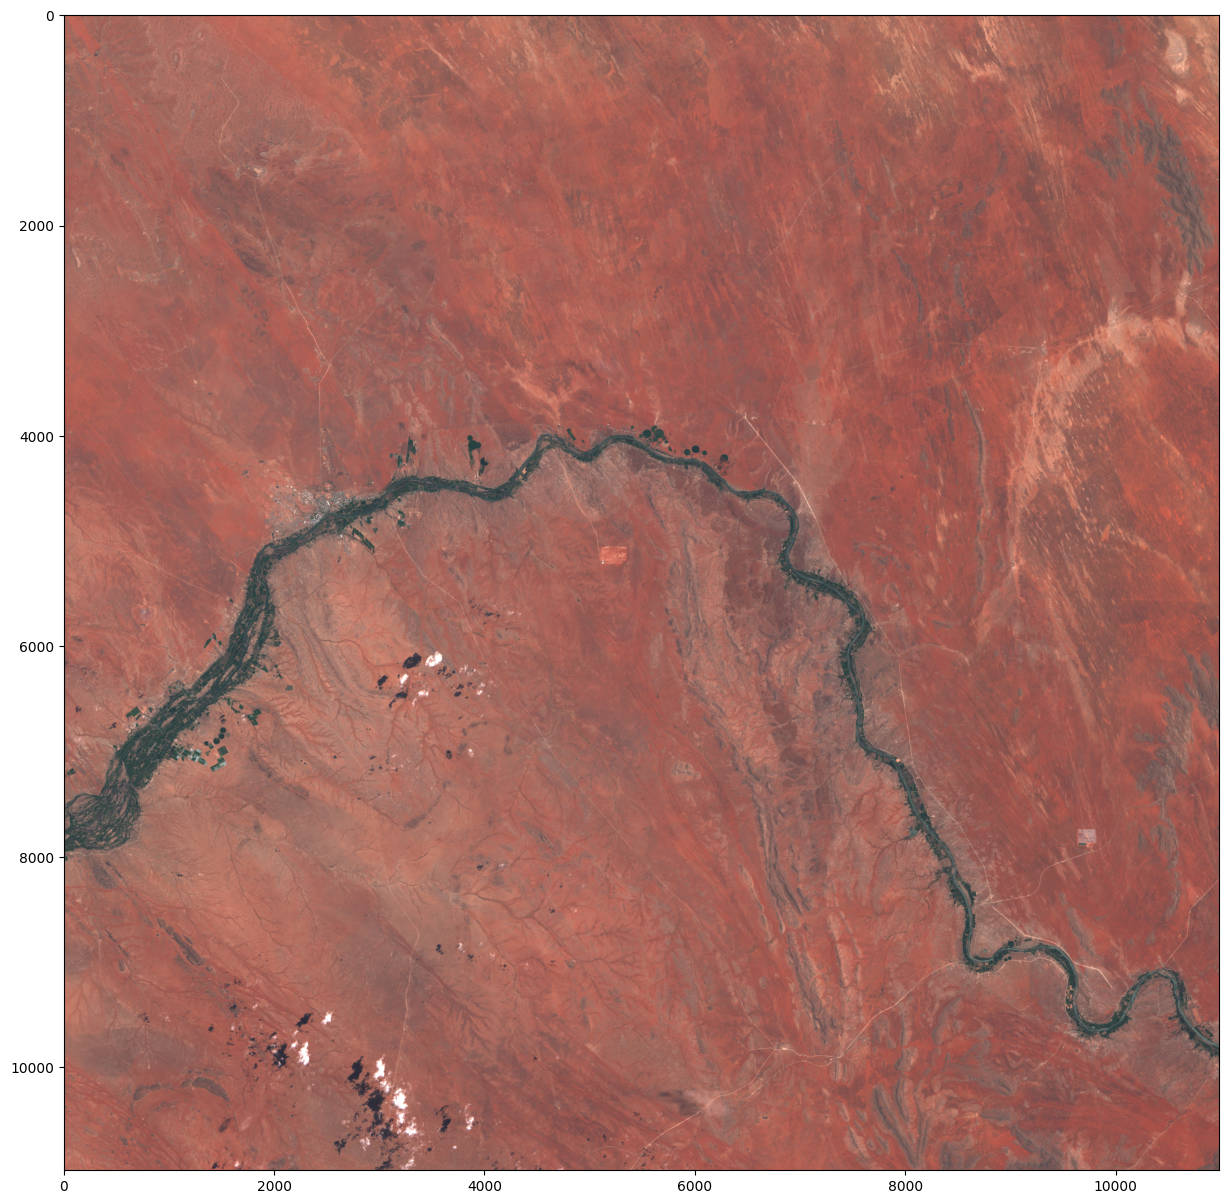

In [5]:
raster_img = reshape_as_image(raster_img)

# visualization by matplotlib
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

In [6]:
train_df = gpd.read_file("data/train/train/train.shp")
print(len(train_df))
train_df.head(5)

2497


,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
0,1,0.915905,3,8,"POLYGON ((2467881.175 -3352032.059, 2468026.16..."
1,2,2.064410,3,6,"POLYGON ((2468428.906 -3351993.173, 2468346.03..."
2,3,1.080300,3,8,"POLYGON ((2468333.745 -3352058.485, 2468336.65..."
3,4,1.316190,3,8,"POLYGON ((2468607.858 -3352012.338, 2468597.53..."
4,7,5.529220,3,8,"POLYGON ((2468646.085 -3351706.202, 2468490.77..."


In [15]:
train_df['geometry'].type.value_counts(dropna=False)

Polygon         2488
MultiPolygon       6
None               3
Name: count, dtype: int64

In [13]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [2467881.1750413314, 2468026.166997987, 2468030.9295075075, 2467906.045924405, 2467881.1750413314]),
 array('d', [-3352032.0592964217, -3352002.1613220456, -3352046.3468240052, -3352113.021952709, -3352032.0592964217]))

#### Masking

`rasterio.mask.mask` is a function in the rasterio library that allows you to mask (or clip) a raster dataset using one or more geometric shapes. Essentially, it's a way to extract a subset of your raster data based on some geometry, which could be a polygon, point, line, etc. Everything outside of this geometry will be masked out.

Here's a basic breakdown of what the function does:

* Masking: It sets the values of the pixels outside the geometry to a specified nodata value, essentially "masking" them out.  

* Cropping: Optionally, it can also crop the raster to the smallest bounding box that contains the geometry, which means it will reduce the size of the raster to just the area of interest.  

Parameters to note:

`dataset`: The raster dataset you want to mask, typically opened with rasterio.open().

`shapes`: A list of geometries, in the form of GeoJSON-like Python dictionaries. These geometries determine the area you want to keep (unmasked).

`crop`: A boolean parameter. If True, it crops the raster to the extent of the shapes.

`invert`: A boolean parameter. If True, it masks the area inside the geometry instead of outside.

In [14]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 2497 files


**Note:** Rasterio failed to mask the data. The problem is that .shp CRS doesn’t match the CRS of the raster. We need to convert them manually.

In [19]:
# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# assigning crs
train_df.crs = {'init' :'epsg:3395'} 

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

/home/main/PycharmProjects/CropImageAnalysis/venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/main/PycharmProjects/CropImageAnalysis/venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### How to find out what CRS should be assigned

1. Source Metadata: Often, spatial datasets come with metadata that specifies the CRS. This can be in the form of a .prj file for shapefiles, or metadata embedded within formats like GeoTIFFs or GeoJSONs. Always check for any accompanying documentation or metadata files.

2. Original Data Provider: If you obtained your data from an organization, government agency, or any data provider, they often provide details about the CRS in accompanying documentation or on their website.

3. Context: Think about where the data is from:

    * Is it from a local, regional, or national source? Local datasets might use a local or state-specific projected CRS.
    * Is it global data? Global datasets might use a geographic CRS like WGS 84 (EPSG:4326).
4. Visual Checks: If you have other known datasets (with a known CRS) covering the same area, you can load both datasets into a GIS software (like QGIS) and see if they align. If not, you can try reprojecting your dataset into different CRSs and see which one aligns best.

5. Known Default CRSs: Some platforms or tools have default CRSs. For instance, data from the Web Mercator projection (EPSG:3857) is common for web maps like Google Maps, Bing Maps, and OpenStreetMap.

6. Investigate the Units: If coordinates look like they're in degrees and range between -180 to 180 (longitude) and -90 to 90 (latitude), the data might be in a geographic CRS like WGS 84. If coordinates are in meters or feet, it's likely a projected CRS.

7. CRS Repositories: Websites like epsg.io or spatialreference.org allow you to search for CRSs by region or country, which can be helpful if you know the general location of your data.

8. Consult with Colleagues or Forums: If you're still unsure, colleagues with GIS experience, or online forums and communities (e.g., GIS Stack Exchange), can be valuable resources.

In [20]:
train_df['geometry'].type.value_counts(dropna=False)

Polygon         2488
MultiPolygon       6
Name: count, dtype: int64

In [21]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "data/train/train_masked"
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['Field_Id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
        print(e)
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap 

/tmp/ipykernel_6712/982448503.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


set()


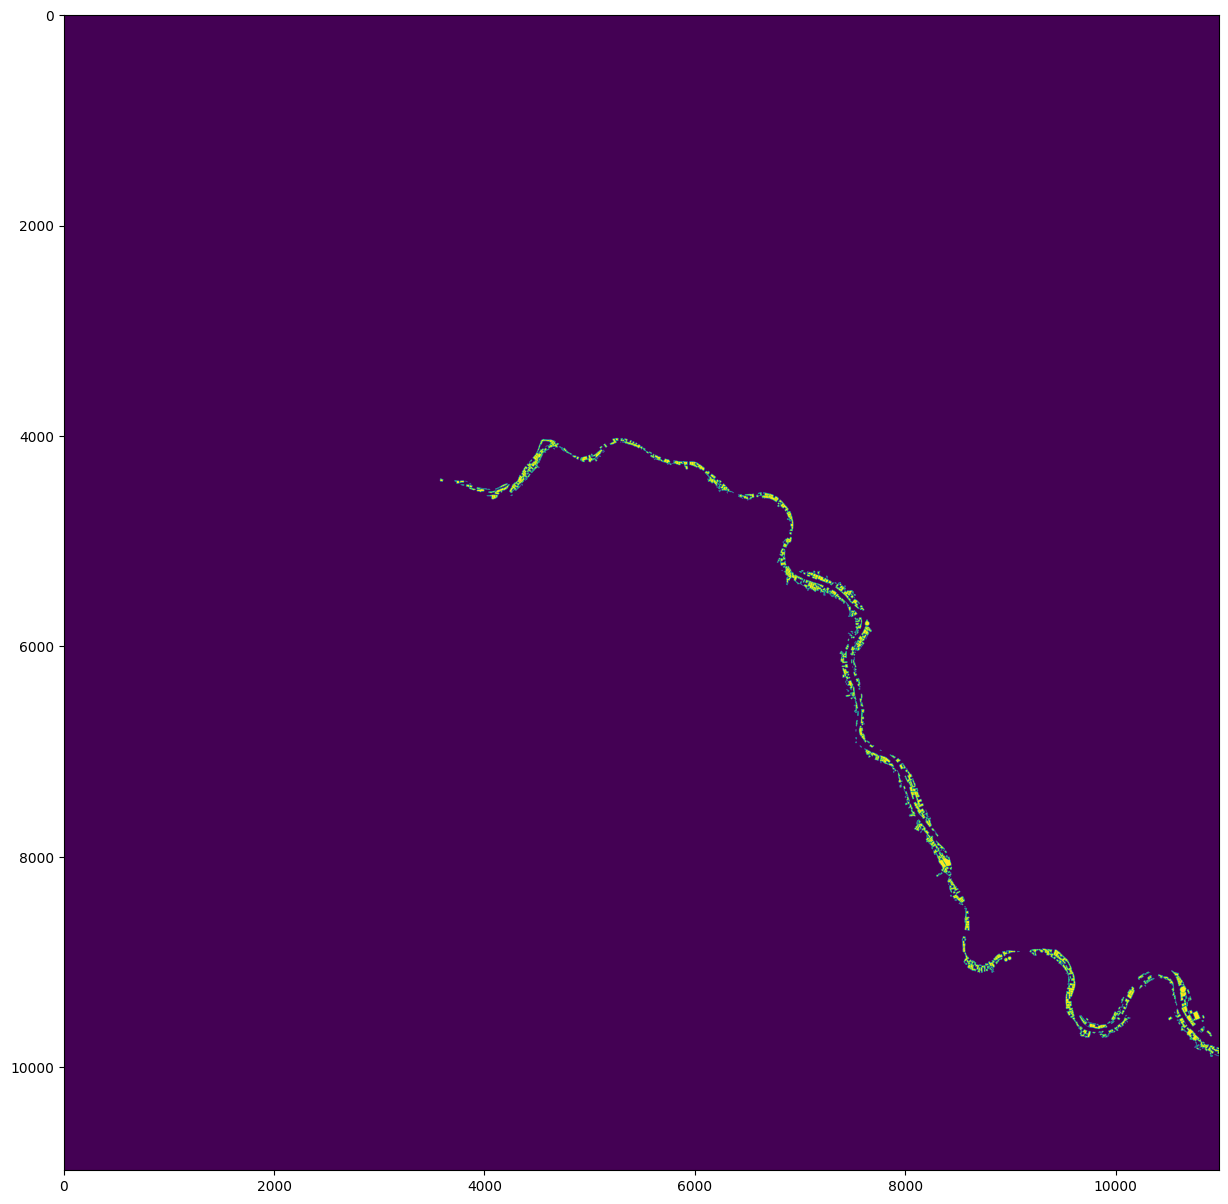

In [23]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry'].geoms:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

In [31]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("data/train/train_binary_segmentation.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

### Check other images

data/2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B8A.jp2
1
JP2OpenJPEG
(None,)
214
28000


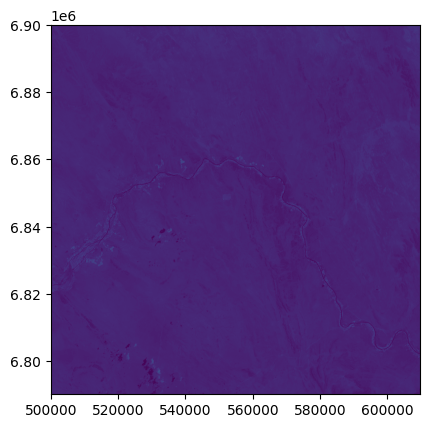

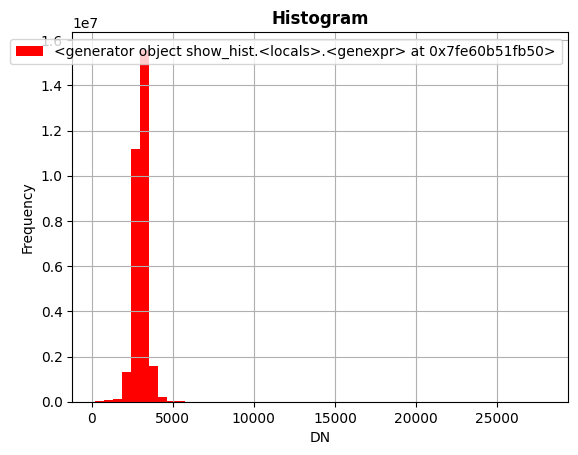

In [27]:
# other images

raster_path = "data/2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B8A.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:  # open image in the read mode
    raster_img = src.read()   # read image as numpy array
    raster_meta = src.meta    # metadata of the image
    
    print(src.name)
    print(src.count)
    print(src.driver)
    print(src.descriptions)
    print(raster_img.min())
    print(raster_img.max())
    
    # visualization by rasterio
    show(src)
    show_hist(src, bins=50)

### Masks for multiclass classification

In [30]:
# types of crop
train_df['Crop_Id_Ne'].value_counts(dropna=False)

Crop_Id_Ne
8    941
4    536
5    283
7    267
6    146
1    142
3     95
9     77
2      7
Name: count, dtype: int64

/tmp/ipykernel_6712/982448503.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)
/tmp/ipykernel_6712/982448503.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)
/tmp/ipykernel_6712/982448503.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)
/tmp/ipykernel_6712/982448503.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)
/tmp/ipykernel_6712/982448503.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)
/tmp/ipykernel_6712/982448503.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
 

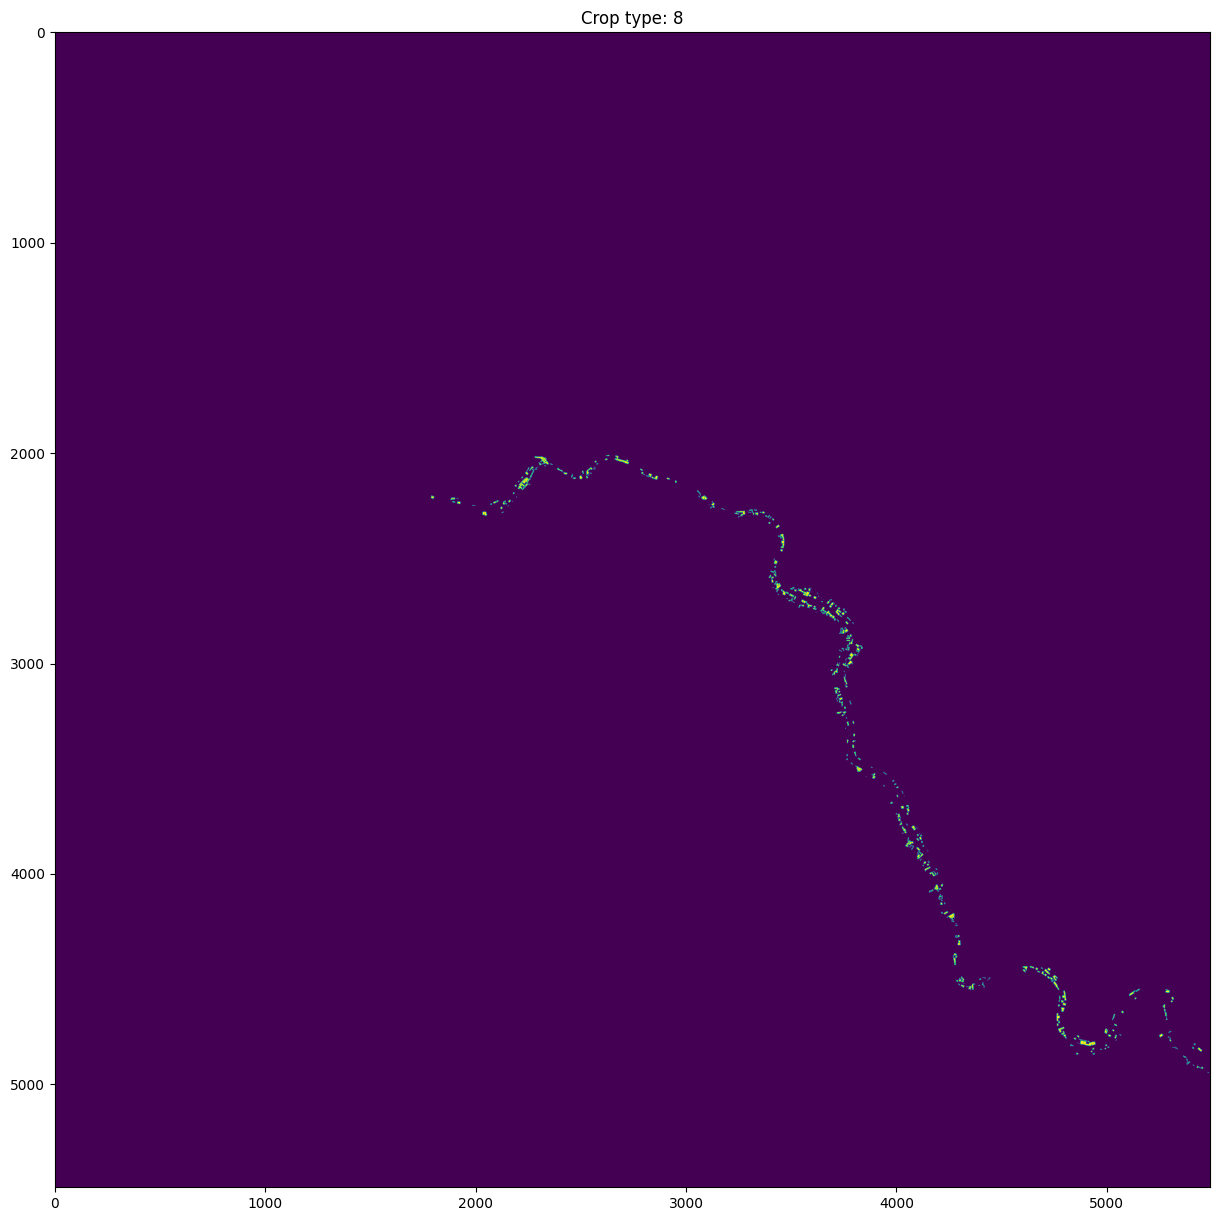

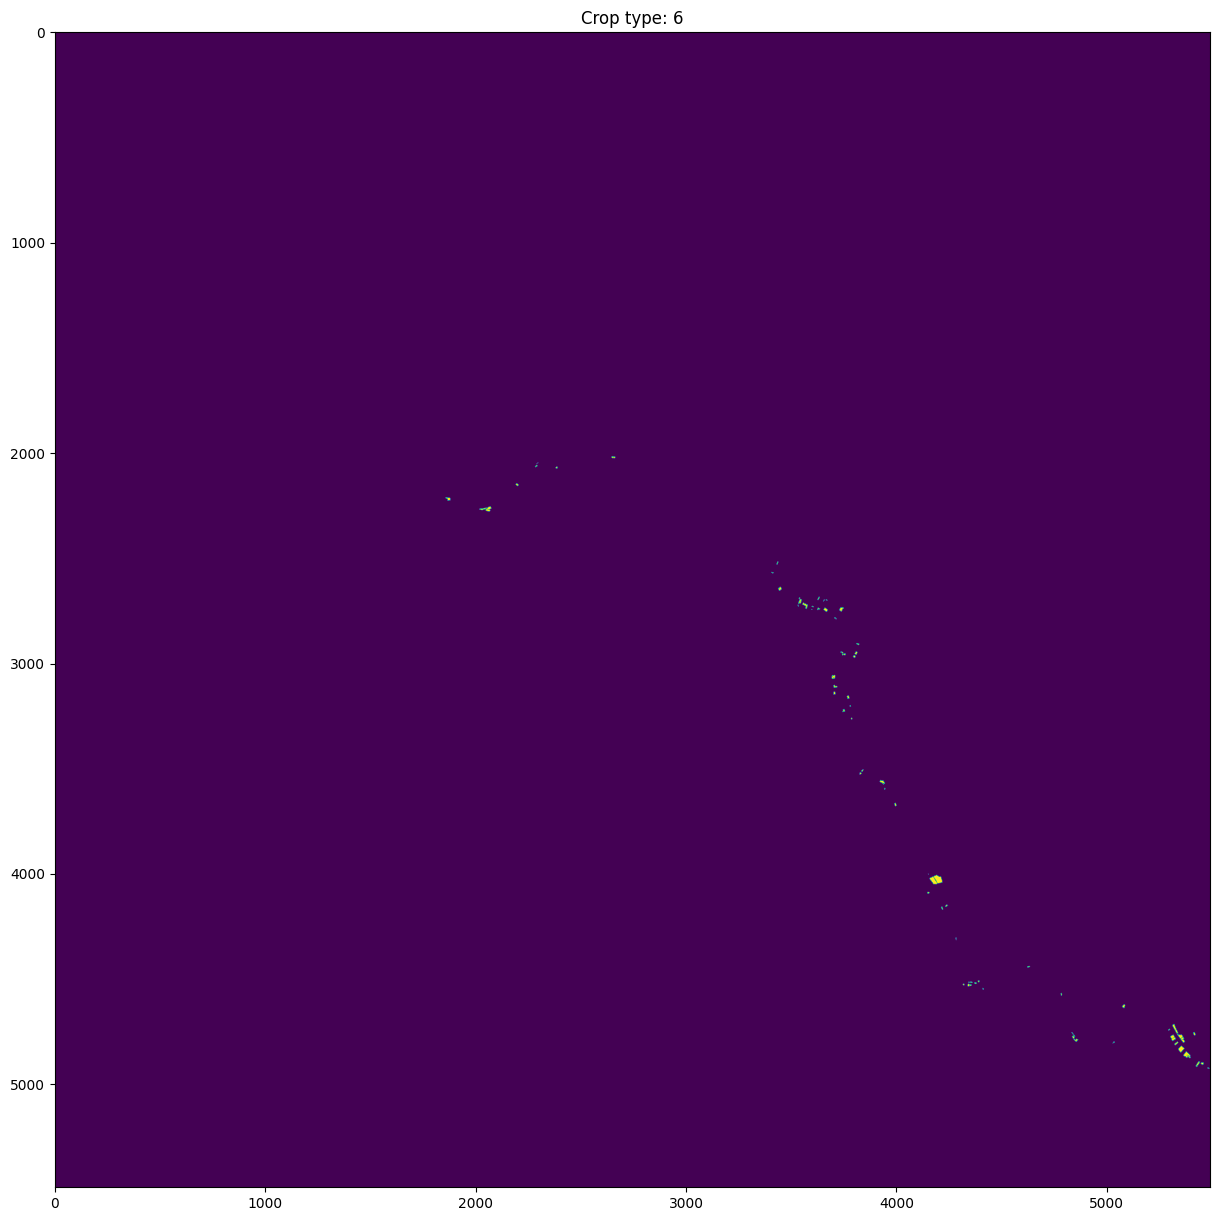

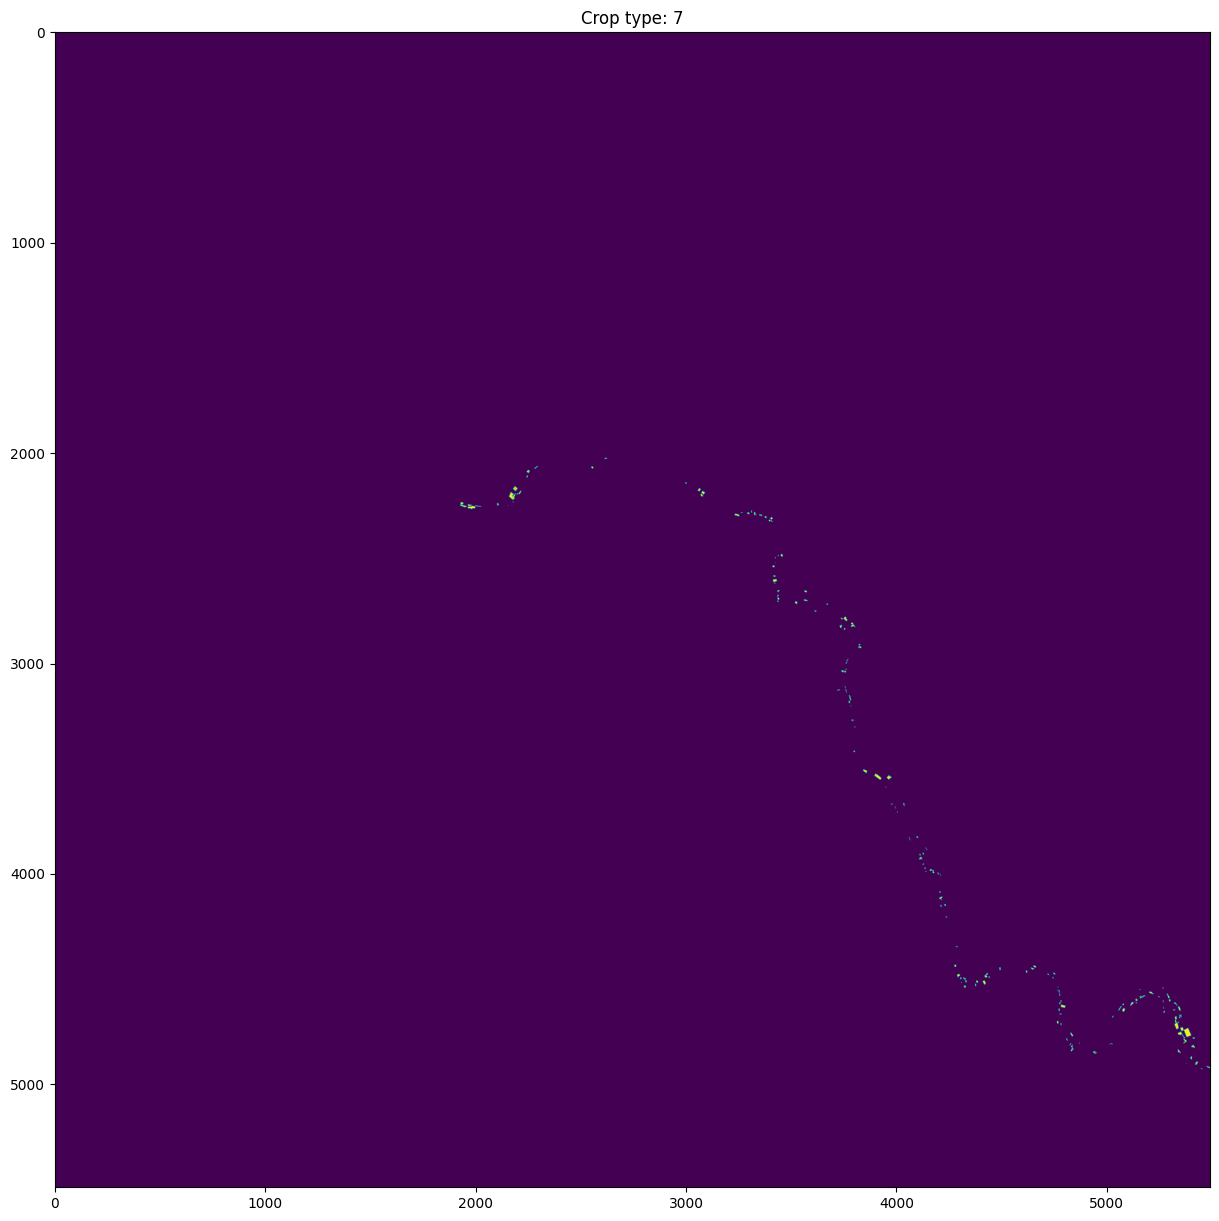

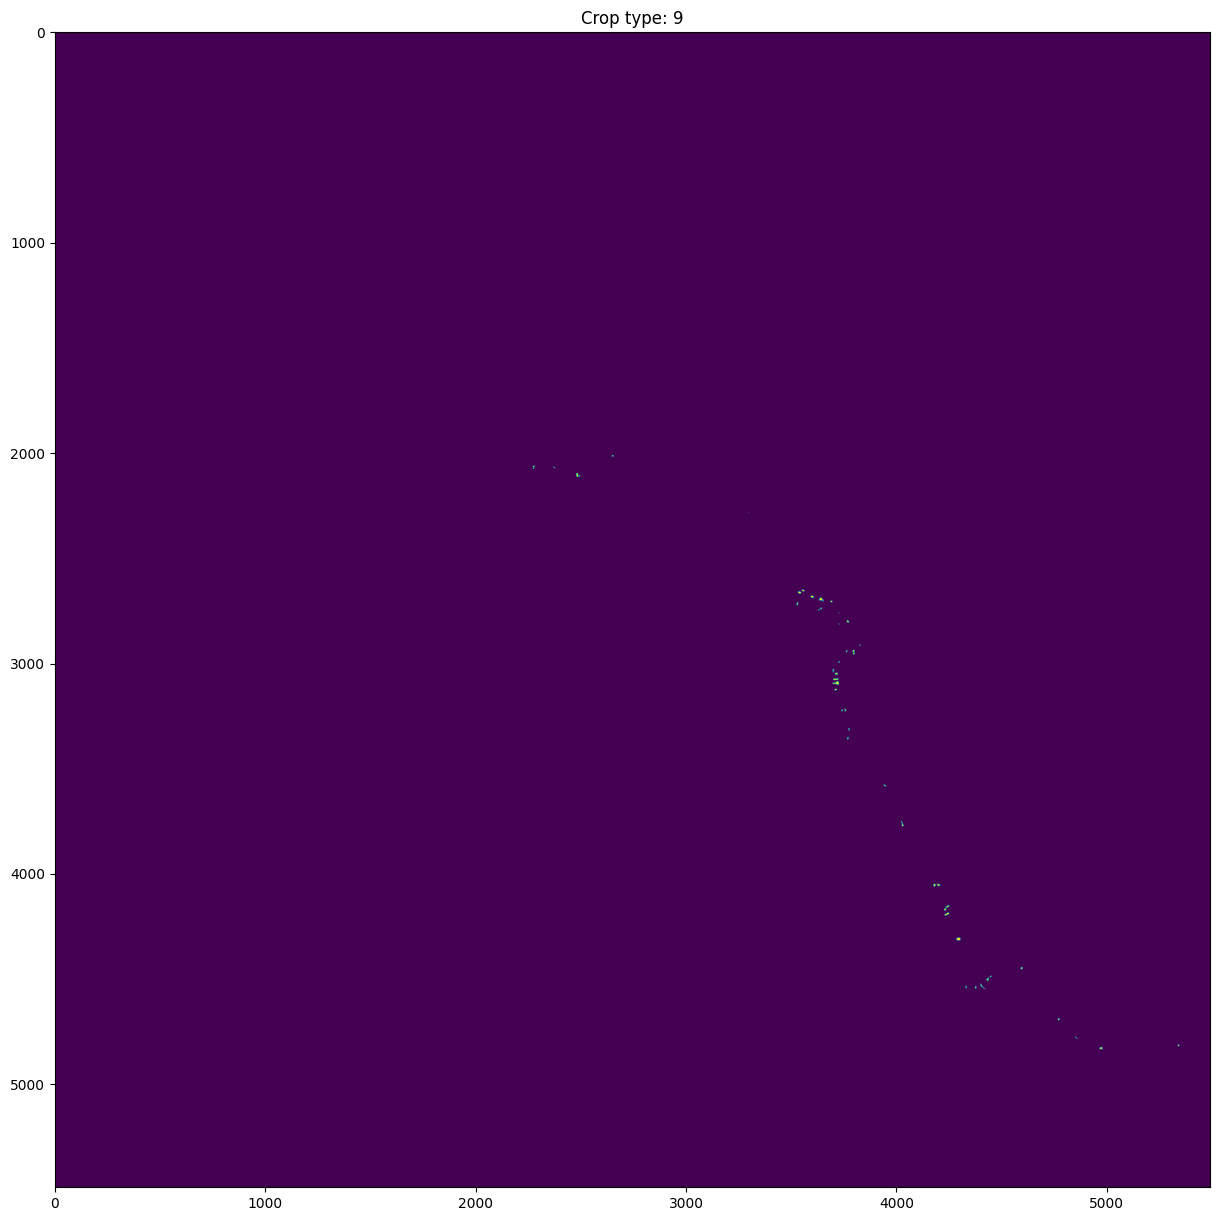

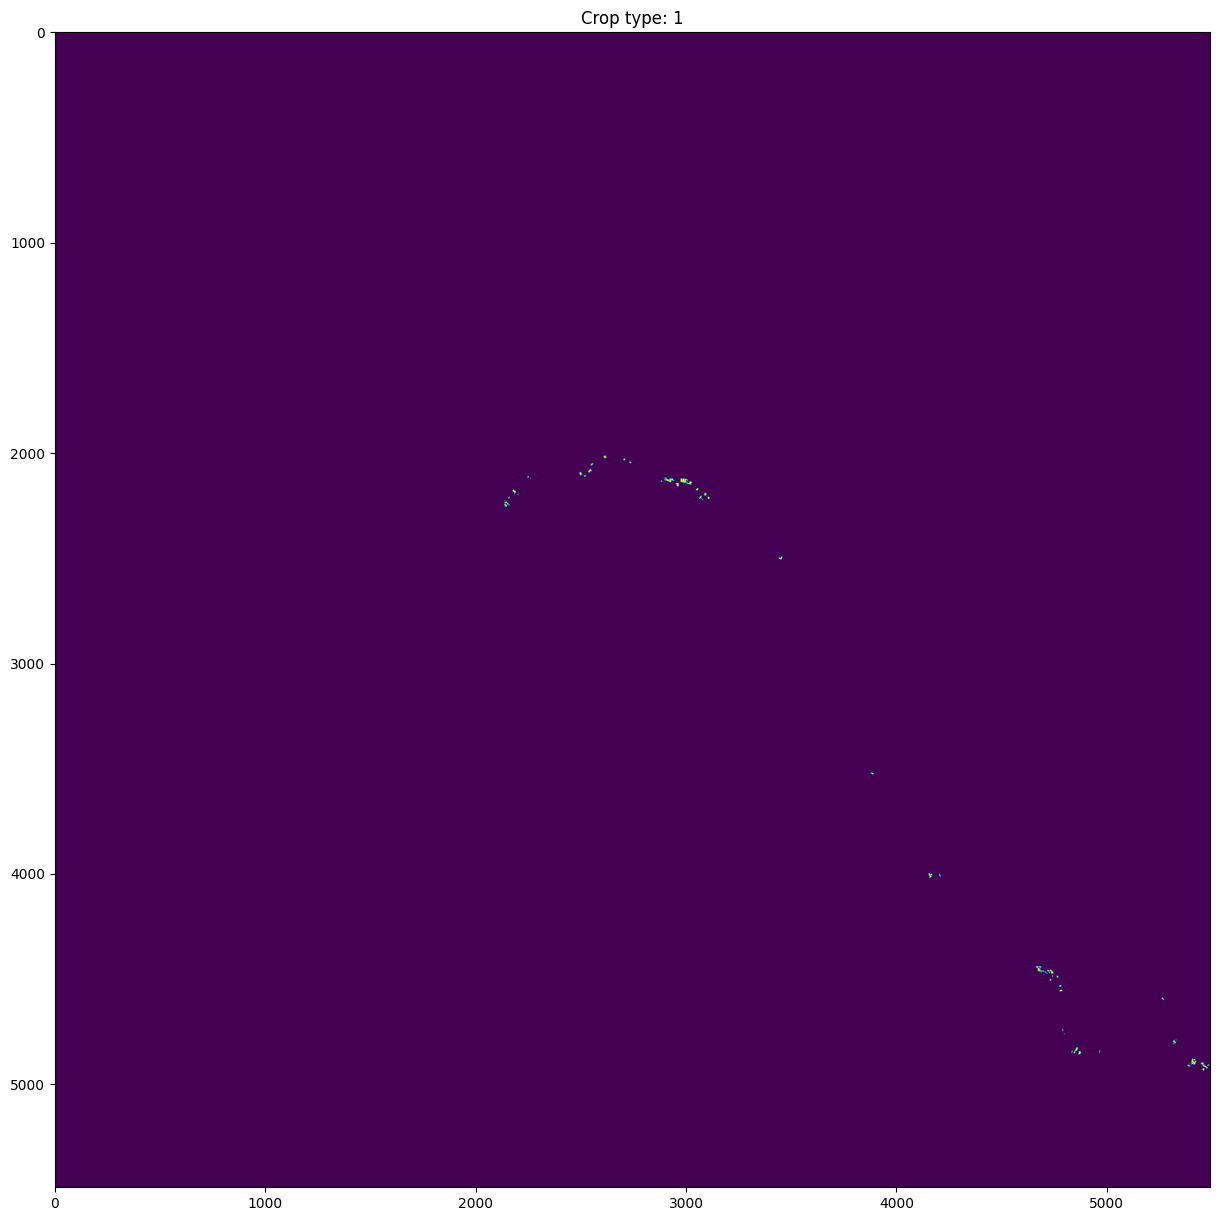

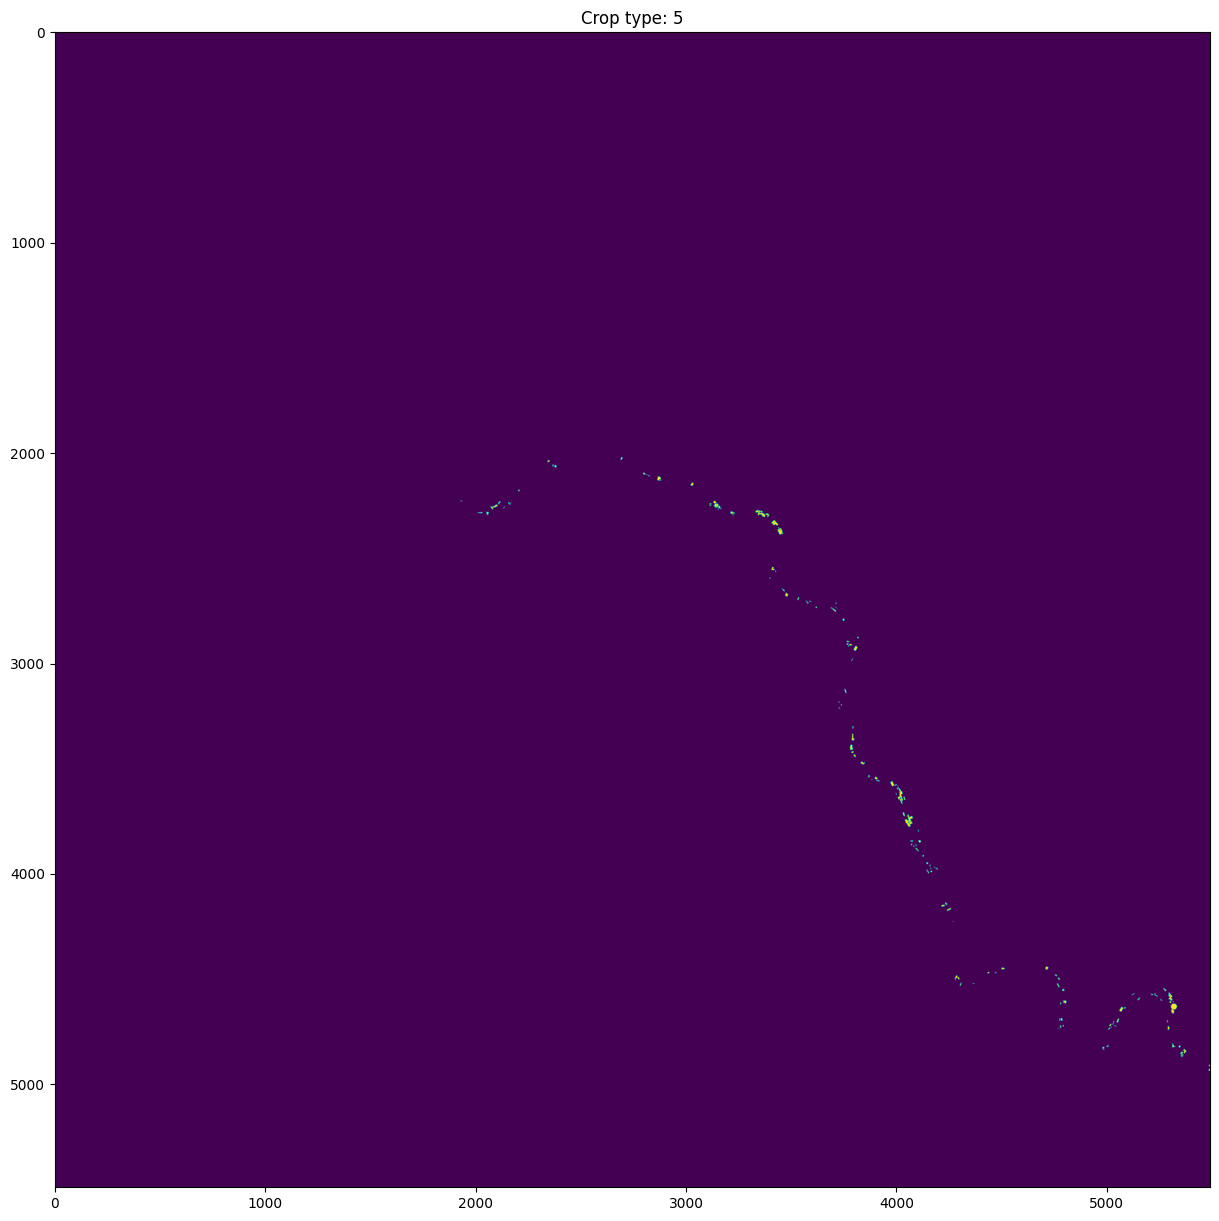

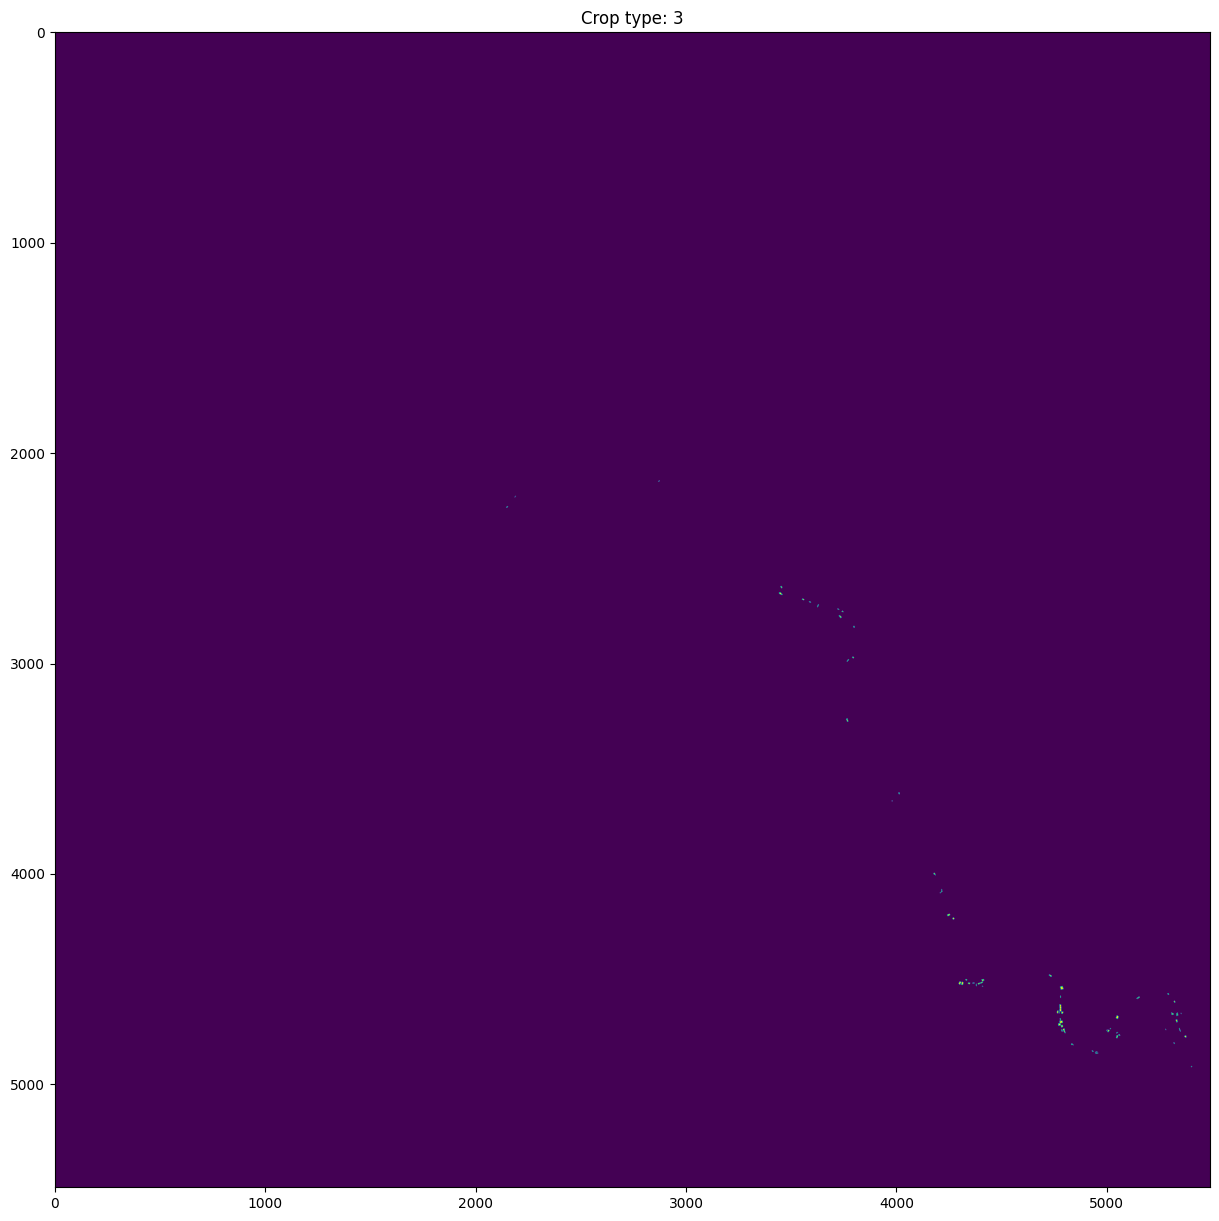

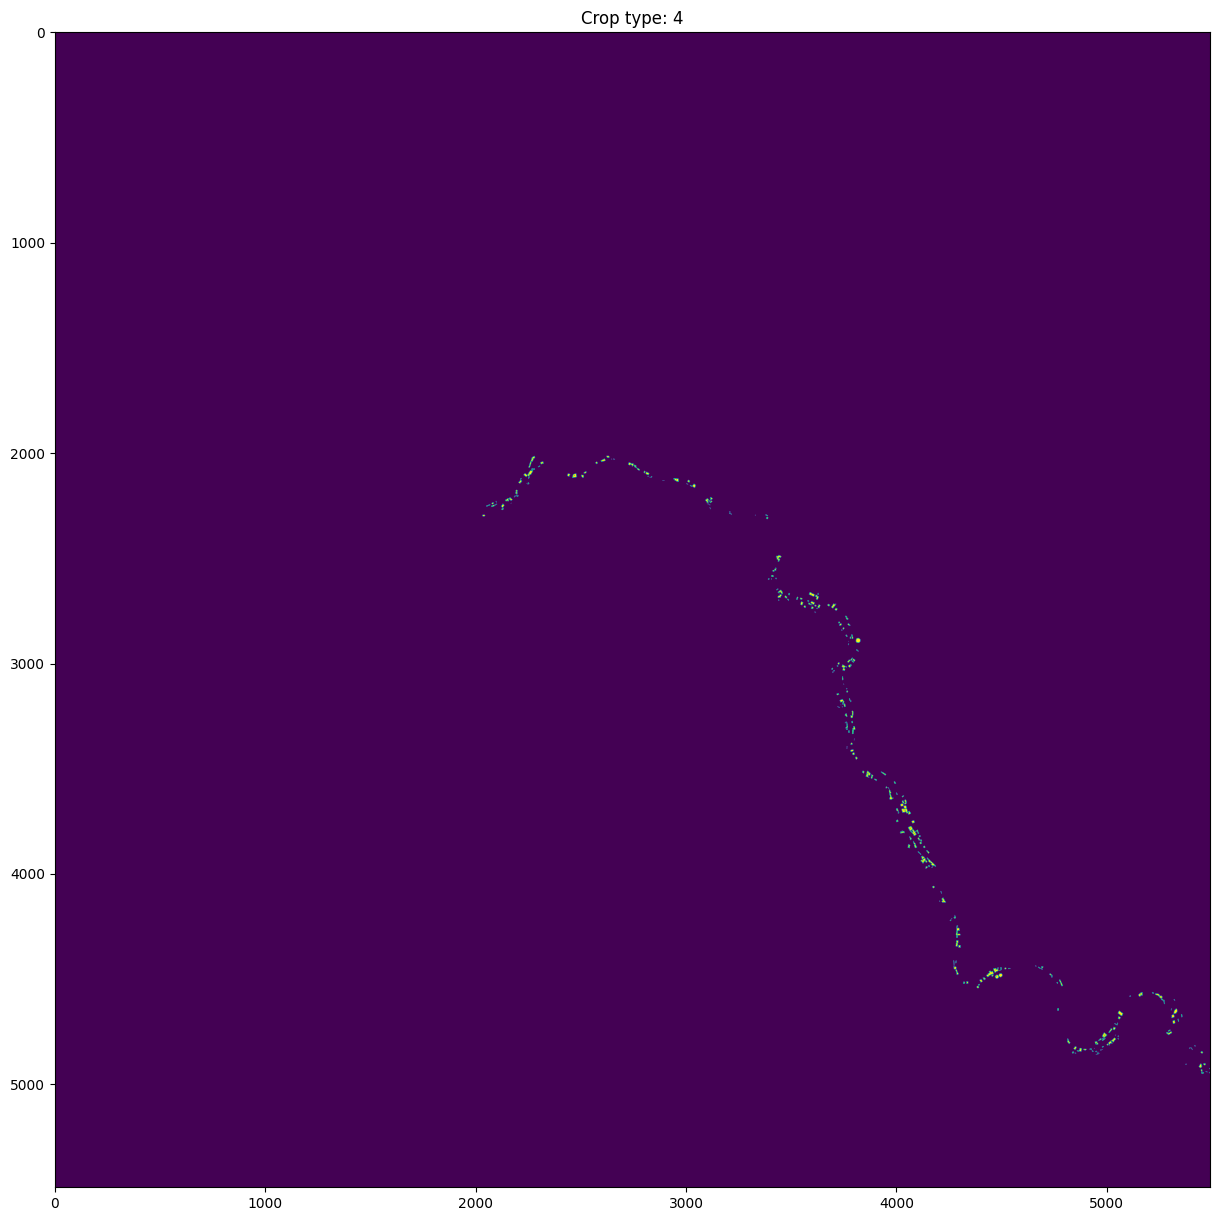

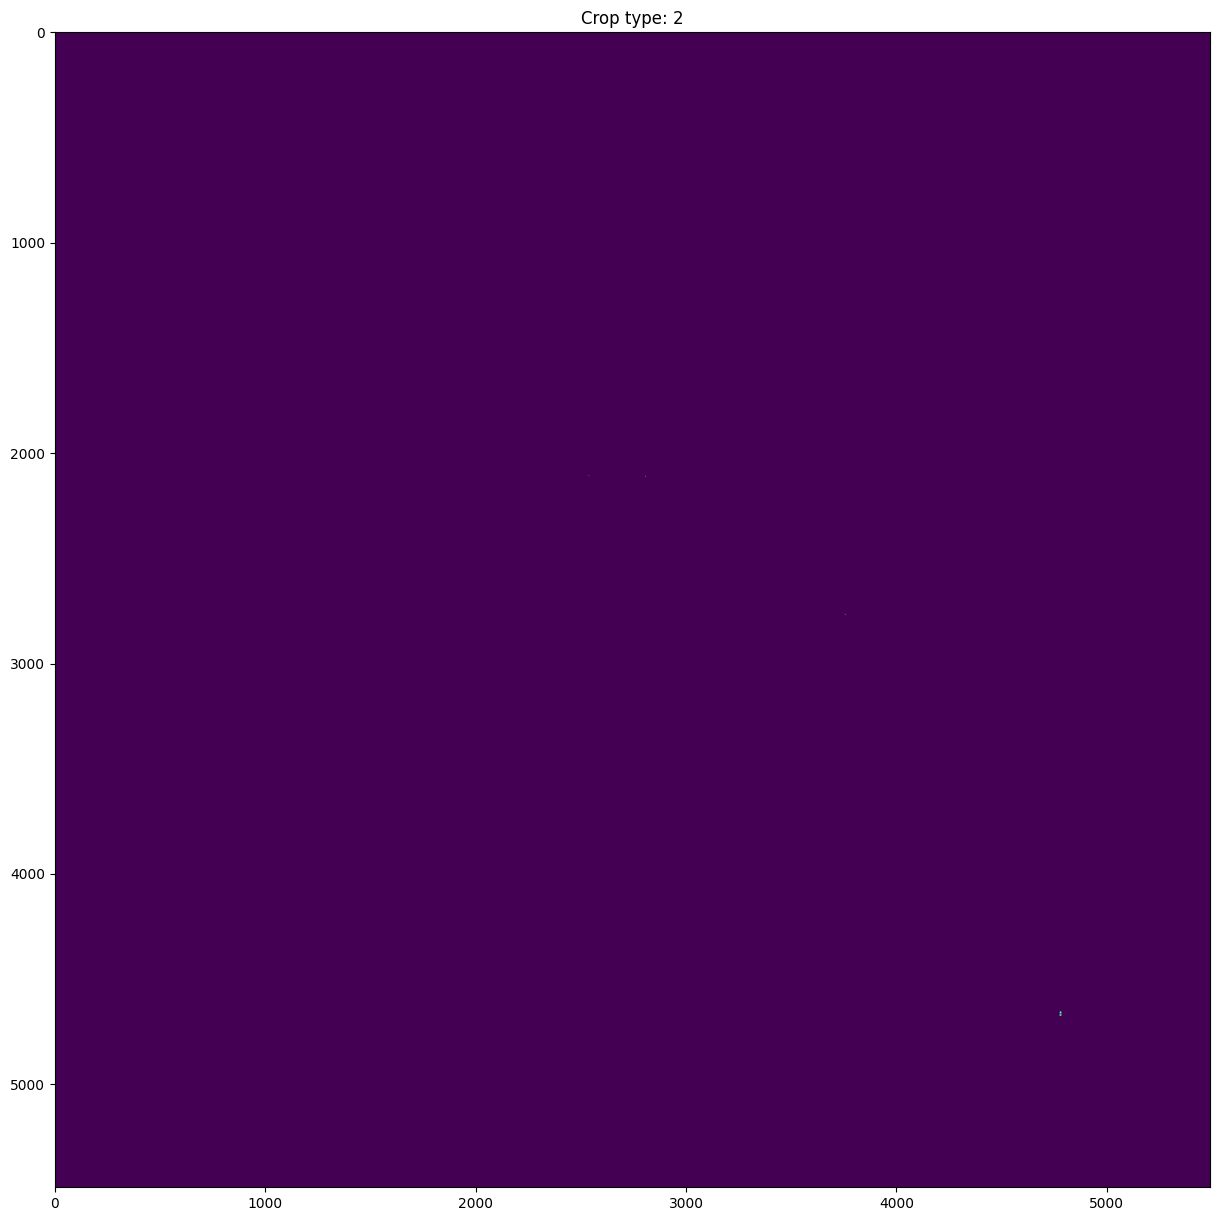

In [34]:
outfolder = 'data/train/multiclass_segmentation_masks'

for crop_type in train_df['Crop_Id_Ne'].unique():
    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    df = train_df[train_df['Crop_Id_Ne'] == crop_type]
    for num, row in df.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            for p in row['geometry'].geoms:
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append(poly)

    mask = rasterize(shapes=poly_shp, out_shape=im_size)
    # plotting the mask
    plt.figure(figsize=(15,15))
    plt.title('Crop type: ' + str(crop_type))
    plt.imshow(mask)
    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    mask_name = 'train_' + str(crop_type) + '.jp2'
    save_path = os.path.join(outfolder, mask_name)
    with rasterio.open(save_path, 'w', **bin_mask_meta) as dst:
        dst.write(mask * 255, 1)
    